In this notebook we aim to develop a protocole to evaluate OLAF pipelines:


To achieve this task , we will follow this steps:

- Select a corpus.
- Select and create relevent concepts from the corpus.
- Create several pipelines with different components and parameters.
- Run all the pipelines.
- Find concepts involved in complete triples (relation with no null source and destination concepts) for each pipeline.
- Etablish the matching percentage of found concepts compared to selected concepts on step 2.


In [1]:
import spacy
from typing import Set, List
import pandas as pd
from olaf import Pipeline
from olaf.commons.logging_config import logger
from olaf.data_container import CandidateTerm, Relation, Concept
from olaf.data_container.knowledge_representation_schema import KnowledgeRepresentation
from olaf.pipeline.pipeline_component.term_extraction import (
    POSTermExtraction,
    TFIDFTermExtraction,
    ManualCandidateTermExtraction
    )
from olaf.pipeline.pipeline_component.concept_relation_extraction import (
    CTsToConceptExtraction,
    CTsToRelationExtraction,
    SynonymRelationExtraction,
    SynonymConceptExtraction,
    AgglomerativeClusteringRelationExtraction,
    AgglomerativeClusteringConceptExtraction
)
from olaf.commons.spacy_processing_tools import is_not_punct, is_not_stopword, select_on_pos

from olaf.pipeline.pipeline_component.candidate_term_enrichment import SemanticBasedEnrichment

from olaf.repository.corpus_loader.text_corpus_loader import TextCorpusLoader

/home/oumar/Bureau/ontology-learning/env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
nlp = spacy.load("en_core_web_lg")

# Select Corpus

In [3]:
corpus_path = "GC10-DET_doc.txt"
corpus_loader = TextCorpusLoader(corpus_path)
# corpus = [doc[:-1] for doc in corpus]
# corpus

# Select and create relevent concepts from the corpus.


In [4]:
expected_concepts = []
with open("concepts.txt", 'r') as f:
    lines = f.readlines()
    expected_concepts = [concept.rstrip("\n") for concept in lines]
    expected_concepts = [Concept(concept) for concept in expected_concepts]
    f.close()

print(expected_concepts)


[Punching, Welding line, Crescent Gap, Water spot, Oil spot, Silk spot, Inclusion, Rolled pit, Crease, Waist folding, metal surface defect, mechanical failure, drying, mechanical lubricant, temperature, pressure, work roll damage, tension roll damage, local yield, low-carbon]


# Testing concept ratio function

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util


def is_similar(concept_a : str, concept_b: str, nlp =nlp, threshold=.8):
    vector_a, vector_b = nlp(concept_a).vector, nlp(concept_b).vector
    return cosine_similarity([vector_a], [vector_b]) > threshold

def is_equal(concept_a : str, concept_b: str):
    return concept_a.lower() == concept_b.lower()

def hg_lm_similaritiry(concept_a : str, concept_b: str, model=SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"), threshold=.8):
    embedding_a, embedding_b = model.encode(concept_a), model.encode(concept_b)
    return util.pytorch_cos_sim(embedding_a, embedding_b) > threshold

def get_concept_ratio(pipeline : Pipeline, expected_concepts : List[Concept], comparator = hg_lm_similaritiry, comparator_args:dict={}) -> tuple:
    """
    Calculate the ratio of expected and unexpected concepts in a given pipeline.

    Parameters
    ----------
    pipeline : Pipeline
        The pipeline object containing concepts.
    expected_concepts : List[Concept]
        A list of expected concepts.kwargs

    Returns
    -------
    Tuple[float, float]: A tuple containing:
        The percentage of expected concepts found in the pipeline.
        The percentage of unexpected concepts in the pipeline.
    """
    
    
    found_concepts = pipeline.kr.concepts
    if len(found_concepts) > 0:
        found_concepts = [found_concept.label for found_concept in found_concepts]
        expected_concepts = [expected_concept.label for expected_concept in expected_concepts]
        expected_concept_occ = 0
        for expected_concept in expected_concepts:
            for found_concept in found_concepts:
                if comparator(expected_concept, found_concept, **comparator_args):
                    expected_concept_occ += 1
                    break 

        precision = expected_concept_occ/len(expected_concepts)
        recall = expected_concept_occ/len(found_concepts)
        f1 = 2*(precision * recall)/(precision+recall)
        return ([precision, recall, f1], ())
    else:
        return (0, 0, 0)

In [6]:
from olaf.pipeline.pipeline_component.term_extraction.manual_candidate_terms import (
    ManualCandidateTermExtraction,
)
from olaf.pipeline.pipeline_component.concept_relation_extraction.candidate_terms_to_concepts import CTsToConceptExtraction

from olaf.pipeline.pipeline_component.concept_relation_extraction.candidate_terms_to_relations import CTsToRelationExtraction


# concept extraction component
concepts = [
    "defect type",
    "steel strip surface",
    "punching",
    "mechanical failure",
    "welding line",
    "coil",
    "weld line",
    "crescent gap",
    "cutting",
    "water spot",
    "drying",
    "oil spot",
    "mechanical lubricant",
    "silk spot",
    "plaque",
    "strip surface",
    "roller",
    "pressure",
    "inclusion",
    "metal surface",
    "spots",
    "fish scale shape",
    "block irregular distribution",
    "rolled pit",
    "bulges",
    "pits",
    "steel plate",
    "work roll",
    "tension roll",
    "damage",
    "crease",
    "fold",
    "uncoiling process",
    "waist folding",
    "deformation",
    "low-carbon"
]

relations = [
    "described",
    "explaining",
    "appears",
    "leads",
    "resulting",
    "changed",
    "produced",
    "drying",
    "caused",
    "affect",
    "appearing",
    "lies",
    "distributed",
    "accompanied",
    "showing",
    "pressed",
    "occurred",
    "circumvented",
    "detected",
    "tracked",
    "results",
    "like",
    "mainly",
    "uncoiling"
]

ct_concept_label = { concept : {concept} for concept in concepts}

manuel_concept_extraction = ManualCandidateTermExtraction(
    ct_label_strings_map=ct_concept_label
)

concept_extraction = CTsToConceptExtraction(
)
# concept extraction component



relation_extraction = CTsToRelationExtraction()
pipelines = []
pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            manuel_concept_extraction,
            concept_extraction,
        ],
        corpus_loader=corpus_loader
    )
)

[2024-06-18 13:34:14,396] [WARNING] [candidate_terms_to_relations] [_check_parameters] [No value given for concept_max_distance parameter, default will be set to 5.]


In [7]:
current_pipeline = pipelines[-1]
current_pipeline.run()

get_concept_ratio(current_pipeline, expected_concepts)

(0.8, 0.45714285714285713, 0.5818181818181818)

In [8]:
def debug_get_concept_ratio(pipeline : Pipeline, expected_concepts : List[Concept], comparator = hg_lm_similaritiry, comparator_args:dict={}) -> tuple:
    """
    Calculate the ratio of expected and unexpected concepts in a given pipeline.

    Parameters
    ----------
    pipeline : Pipeline
        The pipeline object containing concepts.
    expected_concepts : List[Concept]
        A list of expected concepts.kwargs

    Returns
    -------
    Tuple[float, float]: A tuple containing:
        The percentage of expected concepts found in the pipeline.
        The percentage of unexpected concepts in the pipeline.
    """
    
    
    found_concepts = pipeline.kr.concepts
    if len(found_concepts) > 0:
        found_concepts = [found_concept.label for found_concept in found_concepts]
        expected_concepts = [expected_concept.label for expected_concept in expected_concepts]
        expected_concept_occ = 0
        for expected_concept in expected_concepts:
            print()
            print(f"{expected_concept} : ", end="")
            for found_concept in found_concepts:
                if comparator(expected_concept, found_concept, **comparator_args):
                    print(f"{found_concept} ", end="")
                    expected_concept_occ += 1
                    break 

    
        precision = expected_concept_occ/len(expected_concepts)
        recall = expected_concept_occ/len(found_concepts)
        f1 = 2*(precision * recall)/(precision+recall)
        return (precision, recall, f1)
    else:
        return (0, 0, 0)



current_pipeline = pipelines[-1]
debug_get_concept_ratio(current_pipeline, expected_concepts)


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : waist folding 
metal surface defect : 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : 
tension roll damage : tension roll 
local yield : 
low-carbon : low-carbon 

(0.8, 0.45714285714285713, 0.5818181818181818)

In [9]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold":.7})


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : waist folding 
metal surface defect : metal surface 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : work roll 
tension roll damage : tension roll 
local yield : 
low-carbon : low-carbon 

(0.9, 0.5142857142857142, 0.6545454545454545)

In [10]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator=is_equal)



Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : water spot 
Oil spot : oil spot 
Silk spot : silk spot 
Inclusion : inclusion 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : waist folding 
metal surface defect : 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : 
tension roll damage : 
local yield : 
low-carbon : low-carbon 

(0.75, 0.42857142857142855, 0.5454545454545454)

In [11]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold":.5})


Punching : punching 
Welding line : welding line 
Crescent Gap : crescent gap 
Water spot : spots 
Oil spot : spots 
Silk spot : spots 
Inclusion : inclusion 
Rolled pit : pits 
Crease : crease 
Waist folding : waist folding 
metal surface defect : steel strip surface 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : 
pressure : pressure 
work roll damage : damage 
tension roll damage : tension roll 
local yield : 
low-carbon : low-carbon 

(0.9, 0.5142857142857142, 0.6545454545454545)

## Optimze the similarity threshold


In [12]:
print(get_concept_ratio(current_pipeline, expected_concepts)) # default threshold is 0.8
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.7}))
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.6}))
print(get_concept_ratio(current_pipeline, expected_concepts, comparator_args={"threshold": 0.5}))

comparator_args={"threshold": 0.7}

(0.8, 0.45714285714285713, 0.5818181818181818)
(0.9, 0.5142857142857142, 0.6545454545454545)
(0.9, 0.5142857142857142, 0.6545454545454545)
(0.9, 0.5142857142857142, 0.6545454545454545)


# A grid search algorithm for pipelines

In [13]:
class GridSearch:
    def __init__(self) -> None:
        pass

# Usefull function

In [14]:
def display_concept(kr: KnowledgeRepresentation) -> None:
    print("Concepts in KR:")
    for concept in kr.concepts:
        print(concept.label)


def display_relation(kr: KnowledgeRepresentation) -> None:
    print("Relations in KR:")
    for relation in kr.relations:
        if (
            relation.source_concept is not None
            or relation.destination_concept is not None
        ):
            print(
                (
                    relation.source_concept.label,
                    relation.label,
                    relation.destination_concept.label,
                )
            )

def describe_pipeline(pipeline: Pipeline) -> None:
    print(pipeline.__class__.__name__)
    for component in pipeline.pipeline_components:
        print(f"\t {component.__class__.__name__}")

# Creating pipelines

In [15]:
from olaf.pipeline.pipeline_component.term_extraction import (
    ManualCandidateTermExtraction,
    POSTermExtraction,
    TFIDFTermExtraction,
    CvalueTermExtraction
)

from olaf.pipeline.pipeline_component.concept_relation_extraction import (
    CTsToConceptExtraction,
    SynonymConceptExtraction,
    AgglomerativeClusteringConceptExtraction
)


In [16]:
concept_extraction_components = ["CandidatToConcept", "SynonymToConcept", "AgglomerativeClustering"]
term_extraction_components = ["LLM Term Extraction", "POStag Term Extraction", "TFIDF Term Extraction"]
results = pd.DataFrame(
    index=concept_extraction_components,
    columns=term_extraction_components
    )

multi_index = pd.MultiIndex.from_product([
   concept_extraction_components, 
    ["Precision", "Rappel", "F1"]
    ])
pipelines_scores = pd.DataFrame(index=term_extraction_components, columns=multi_index)

pipelines_scores

CandidatToConcept             SynonymToConcept         \
                               Precision Rappel   F1        Precision Rappel   
LLM Term Extraction                  NaN    NaN  NaN              NaN    NaN   
POStag Term Extraction               NaN    NaN  NaN              NaN    NaN   
TFIDF Term Extraction                NaN    NaN  NaN              NaN    NaN   

                            AgglomerativeClustering              
                         F1               Precision Rappel   F1  
LLM Term Extraction     NaN                     NaN    NaN  NaN  
POStag Term Extraction  NaN                     NaN    NaN  NaN  
TFIDF Term Extraction   NaN                     NaN    NaN  NaN

## LLM Term  Extraction

In [17]:
llm_pipelines = []
llm_results = []

### LLM Term  Extraction and Candidat To Concept Extraction

In [18]:
# concept extraction component
concepts = [
    "defect type",
    "steel strip surface",
    "punching",
    "mechanical failure",
    "welding line",
    "coil",
    "weld line",
    "crescent gap",
    "cutting",
    "water spot",
    "drying",
    "oil spot",
    "mechanical lubricant",
    "silk spot",
    "plaque",
    "strip surface",
    "roller",
    "pressure",
    "inclusion",
    "metal surface",
    "spots",
    "fish scale shape",
    "block irregular distribution",
    "rolled pit",
    "bulges",
    "pits",
    "steel plate",
    "work roll",
    "tension roll",
    "damage",
    "crease",
    "fold",
    "uncoiling process",
    "waist folding",
    "deformation",
    "low-carbon"
]

ct_concept_label = { concept : {concept} for concept in concepts}


llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            CTsToConceptExtraction(),
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()


llm_results += list( 
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

(0.9, 0.5142857142857142, 0.6545454545454545)


### LLM Term  Extraction and Synonym Concept Extraction

In [19]:

llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction(),
        ],
            corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()

llm_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

(0.9, 0.5142857142857142, 0.6545454545454545)


### LLM Term  Extraction and Agglomerative Clustering Concept Extraction

In [20]:

llm_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            ManualCandidateTermExtraction(
                ct_label_strings_map=ct_concept_label
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.4
            ),
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = llm_pipelines[-1]
current_pipeline.run()


llm_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:36:33,219] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-18 13:36:33,222] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]


(0.85, 0.5666666666666667, 0.68)


In [21]:
pipelines_scores.loc[term_extraction_components[0]] = llm_results
pipelines_scores

CandidatToConcept                     SynonymToConcept  \
                               Precision    Rappel        F1        Precision   
LLM Term Extraction                  0.9  0.514286  0.654545              0.9   
POStag Term Extraction               NaN       NaN       NaN              NaN   
TFIDF Term Extraction                NaN       NaN       NaN              NaN   

                                           AgglomerativeClustering            \
                          Rappel        F1               Precision    Rappel   
LLM Term Extraction     0.514286  0.654545                    0.85  0.566667   
POStag Term Extraction       NaN       NaN                     NaN       NaN   
TFIDF Term Extraction        NaN       NaN                     NaN       NaN   

                              
                          F1  
LLM Term Extraction     0.68  
POStag Term Extraction   NaN  
TFIDF Term Extraction    NaN

## POS tag Term Extraction

In [22]:
postag_pipelines = []
pos_results = []

### POS tag Term  extraction and Candidat To Concept Extraction

In [23]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader

    )
)
current_pipeline = postag_pipelines[-1]
current_pipeline.run()


pos_results+= list(
    result:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:36:47,564] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-18 13:36:47,573] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]


(0.85, 0.5666666666666667, 0.68)


In [24]:
current_pipeline.run()
current_pipeline.kr.concepts

set()

In [25]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)

(0, 0, 0)

### POS tag Term  extraction and Synonym Concept Extraction

In [26]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction()
        ],
            corpus_loader=corpus_loader
    )
)
current_pipeline = postag_pipelines[-1]
current_pipeline.run()


pos_results+= list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:36:47,820] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-18 13:36:47,822] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]


(0, 0, 0)


### POS tag Term  extraction and Agglomerative clustering Extraction

In [27]:
postag_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            POSTermExtraction(
                pos_selection=["NOUN"]
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.3
            )
        ],
        corpus_loader=corpus_loader
    )
)

current_pipeline = postag_pipelines[-1]
current_pipeline.run()


pos_results += list(
        results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:36:47,987] [WARNING] [pos_term_extraction] [__init__] [No preprocessing function provided for spans. Using the default one.]
[2024-06-18 13:36:47,989] [WARNING] [pos_term_extraction] [_check_parameters] [POS term extraction token sequence attribute not set by the user.
               By default the system will use the entire content of the document.]
[2024-06-18 13:36:47,992] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-18 13:36:47,994] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]
[2024-06-18 13:36:48,123] [WARNING] [agglomerative_clustering_concept_extraction] [run] [No enough candidate terms to run this component :
                agglomerative clustering-based concept extraction ignored.
                ]


(0, 0, 0)


In [28]:
pipelines_scores.loc[term_extraction_components[1]] = pos_results
pipelines_scores

CandidatToConcept                     SynonymToConcept  \
                               Precision    Rappel        F1        Precision   
LLM Term Extraction                  0.9  0.514286  0.654545              0.9   
POStag Term Extraction                 0         0         0                0   
TFIDF Term Extraction                NaN       NaN       NaN              NaN   

                                           AgglomerativeClustering            \
                          Rappel        F1               Precision    Rappel   
LLM Term Extraction     0.514286  0.654545                    0.85  0.566667   
POStag Term Extraction         0         0                       0         0   
TFIDF Term Extraction        NaN       NaN                     NaN       NaN   

                              
                          F1  
LLM Term Extraction     0.68  
POStag Term Extraction     0  
TFIDF Term Extraction    NaN

## TFIDF  Term Extraction

In [29]:
tfidf_pipelines = []

tfidf_results = []

In [30]:
## 

def has_not_stopword(terms : Set[CandidateTerm], nlp=nlp,):
    selected_term = []
    for term in terms:
        if is_not_stopword(nlp(term.label)[0]):
            selected_term.append(term)
    return set(selected_term)

def has_not_punct(terms : Set[CandidateTerm], nlp=nlp,):
    selected_term = []
    for term in terms:
        if not all([is_not_punct(nlp(char)[0]) for char in term.label]):
            selected_term.append(term)
    return set(selected_term)


bad_pos = ["ADP", "PRON", "CCONJ", "PART", "DET", "INTJ", "SCONJ", "NUM"]

def has_not_bad_pos(terms : Set[CandidateTerm], nlp=nlp, pos_to_avoid: List[str]=bad_pos) -> Set[CandidateTerm]:
    selected_term = []
    for term in terms:
        if not any([doc.pos_ in pos_to_avoid for doc in nlp(term.label)]):
            selected_term.append(term)
    return set(selected_term)

def tidf_postprocessing(terms : Set[CandidateTerm], nlp=nlp) -> Set[CandidateTerm]:

    # has_no_punct = lambda term: any([not is_not_punct(term[i]) for i in range(len(term))])
    terms_doc = [nlp(term.label) for term in terms]
    selected_term = [
        term for term in terms
        if  is_not_punct(nlp(term.label)[0])  
            and is_not_stopword(nlp(term.label)[0])
            and has_not_punct(nlp(term.label)[0])
            and has_not_bad_pos(nlp(term.label)[0])
        ]

    return set(selected_term)

def cts_post_processing(cts: set[CandidateTerm], bad_pos=bad_pos) -> set[CandidateTerm]:
    """Post processing on candidate terms.
    Candidate terms with punctuation, stop words or verbs are removed.

    Parameters
    ----------
    cts: set[CandidateTerm]
        Set of candidate terms to filter.

    Returns
    -------
    set[CandidateTerm]
        The candidate terms validated.    
    """
    existing_cts = []
    new_cts = set()
    for ct in cts:
        keep = True
        if len(ct.corpus_occurrences) > 0:
            for co in ct.corpus_occurrences:
                for token in co:
                    if (not (is_not_punct(token)) or not (is_not_stopword(token)) or (token.pos_ in bad_pos)):
                        keep = False
                        break
        else:
            keep = False
        if keep and ct.label not in existing_cts:
            new_cts.add(ct)
            existing_cts.append(ct.label)
    return new_cts

### TFIDF Term Extraction and Candidat To Concept Extraction

In [31]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.05,
                cts_post_processing_functions=[has_not_punct, has_not_bad_pos, has_not_stopword]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:36:48,267] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]
/home/oumar/Bureau/ontology-learning/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(0.8, 0.10810810810810811, 0.19047619047619047)


In [32]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.05,
                cts_post_processing_functions=[cts_post_processing]
            ),
            CTsToConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


# tfidf_results += list(
results=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    # )
print(results)

[2024-06-18 13:39:24,818] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]


(1.0, 0.09090909090909091, 0.16666666666666669)


In [33]:
# concepts = [ concept for concept in current_pipeline.kr.concepts]
# concept = concepts[0]
# for doc in nlp(concept.label):
#     print(doc.pos_)

# [doc.pos_ in ["AUX", "VERB"] for doc in nlp(concept.label)]
# for lr in concept.linguistic_realisations:
#     docs = lr.get_docs()
#     for doc in docs:
#         print(doc)

# pos_list = set()
# [[(doc, doc.pos_ )for doc in nlp(concept.label)] for concept in concepts]
# for concept in concepts:
#     for doc in nlp(concept.label):
#         pos_list.add(doc.pos_)
# pos_list


# for i in range(0, len(concepts), 10):
#     print([[(doc, doc.pos_ ) for doc in nlp(concept.label)] for concept in concepts[i: i+10]])

# [[(doc, doc.pos_ )for doc in nlp(concept.label)] for concept in expected_concepts]
# len(current_pipeline.kr.concepts)
# display_concept(current_pipeline.kr)

In [34]:
debug_get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)


Punching : 

punching 
Welding line : weld line 
Crescent Gap : crescent 
Water spot : water spot 
Oil spot : oil spots 
Silk spot : silk spot 
Inclusion : inclusions 
Rolled pit : rolled pit 
Crease : crease 
Waist folding : folds 
metal surface defect : surface defects 
mechanical failure : mechanical failure 
drying : drying 
mechanical lubricant : mechanical lubricant 
temperature : temperature 
pressure : pressure 
work roll damage : work roll 
tension roll damage : roll damage 
local yield : local yield 
low-carbon : carbon 

(1.0, 0.09090909090909091, 0.16666666666666669)

In [35]:
display_concept(current_pipeline.kr)

Concepts in KR:
surface defects
vertical transverse
subsequent cuts
scale
flaky
crease
fish scale
failure
type
coils
roller
needs
folds
local yield
strip
reason
drying
circle
damage
usually
irregular distribution
local
work roll
distributed
circumvented
rolled pit
fish scale shape
roll
defects
uneven pressure
spacing
appear
punching defects
mechanical
pressed
work
mainly caused
pits
low
oil
popular
periodic bulges
loose
upper
wrinkles
rolled
silk spot
local deformation
low contrast
lower surface
results
production
lower
main reason
little
block irregular
weld
lower surfaces
length direction
steel strip
showing small spots
pressure
parts
indicating
moving direction
water spot
mainly
large
inclusions
changed
easy
folding
strip length direction
transverse fold
defect type
product
rolled pits
showing small
roll damage
different
block irregular distribution
obvious folds
usually detected
vertical transverse fold
deformation
waist
tracked
mistake
yield
like plaque
generally
block
carbon
subs

### TFIDF Term Extraction and Synonym Concept Extraction

In [36]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
           TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.05,
                cts_post_processing_functions=[has_not_punct, has_not_bad_pos, has_not_stopword]
            ),
            SemanticBasedEnrichment(
                threshold=.9
            ),
            SynonymConceptExtraction()
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
    results:=get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
    )
print(results)

[2024-06-18 13:40:52,877] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]


(0.8, 0.10884353741496598, 0.19161676646706588)


### TFIDF Term Extraction and Agglomerative clustering Concept Extraction

In [37]:
tfidf_pipelines.append(
    Pipeline(
        spacy_model=nlp,
        pipeline_components=[
            TFIDFTermExtraction(
                max_term_token_length=3,
                candidate_term_threshold=.05,
                cts_post_processing_functions=[has_not_punct, has_not_bad_pos, has_not_stopword]
            ),
            AgglomerativeClusteringConceptExtraction(
                distance_threshold=.3
            )
        ],
        corpus_loader=corpus_loader
    )
)
current_pipeline = tfidf_pipelines[-1]
current_pipeline.run()


tfidf_results += list(
    get_concept_ratio(current_pipeline, expected_concepts, comparator_args=comparator_args)
)

[2024-06-18 13:43:36,973] [WARNING] [tfidf_term_extraction] [_check_parameters] [Selected token sequence document attribute not set by the user.
                By default the system will use the entire content of the document.]
[2024-06-18 13:43:36,975] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for embedding_model parameter, default will be set to all-mpnet-base-v2.]
[2024-06-18 13:43:36,975] [WARNING] [agglomerative_clustering_concept_extraction] [_check_parameters] [No value given for metric option, default will be set to cosine.]


In [38]:
pipelines_scores.loc[term_extraction_components[2]] = tfidf_results
pipelines_scores

CandidatToConcept                     SynonymToConcept  \
                               Precision    Rappel        F1        Precision   
LLM Term Extraction                  0.9  0.514286  0.654545              0.9   
POStag Term Extraction                 0         0         0                0   
TFIDF Term Extraction                0.8  0.108108  0.190476              0.8   

                                           AgglomerativeClustering            \
                          Rappel        F1               Precision    Rappel   
LLM Term Extraction     0.514286  0.654545                    0.85  0.566667   
POStag Term Extraction         0         0                       0         0   
TFIDF Term Extraction   0.108844  0.191617                    0.75  0.151515   

                                  
                              F1  
LLM Term Extraction         0.68  
POStag Term Extraction         0  
TFIDF Term Extraction   0.252101

# Visualisation des Resultats

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

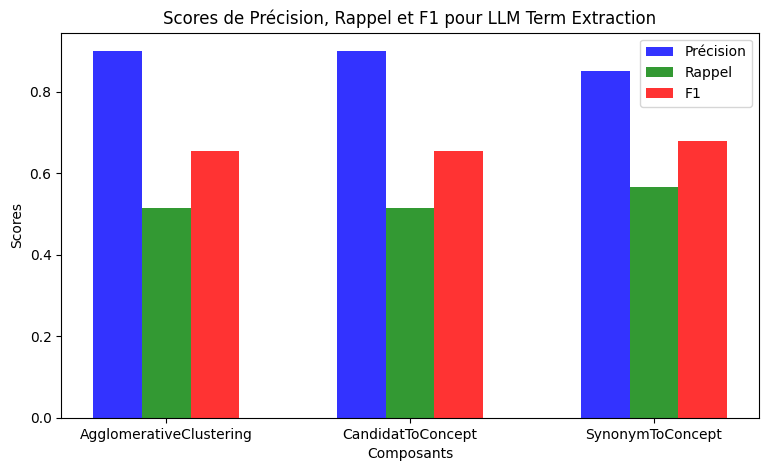

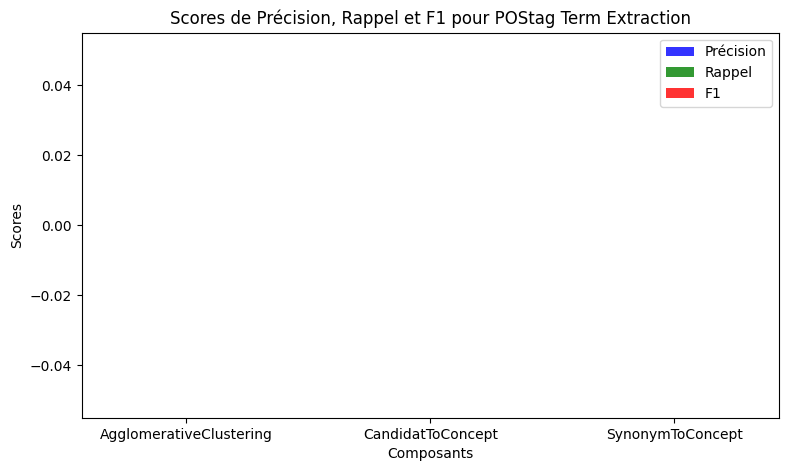

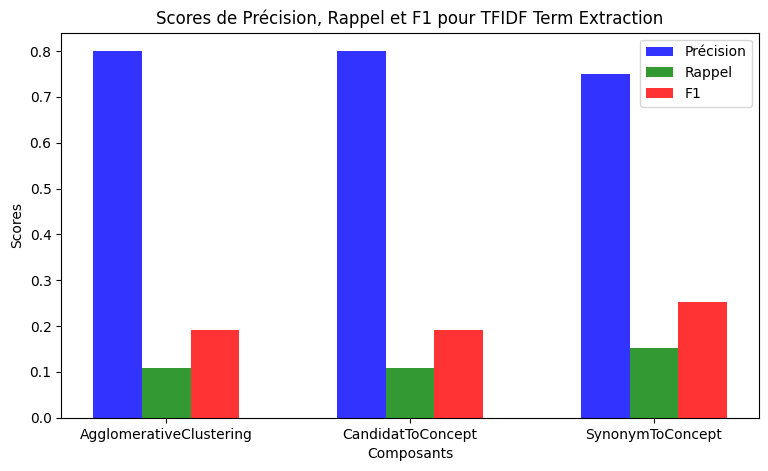

In [40]:
# Fonction pour créer les diagrammes en barres
def create_bar_chart(index_name, data):
    fig, ax = plt.subplots(figsize=(9, 5))
    bar_width = 0.2
    opacity = 0.8

    # Configurer les positions des barres
    r1 = np.arange(len(data.columns.levels[0]))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    precision = data.loc[index_name].xs('Precision', level=1)
    rappel = data.loc[index_name].xs('Rappel', level=1)
    f1 = data.loc[index_name].xs('F1', level=1)

    rects1 = ax.bar(r1, precision, bar_width, alpha=opacity, color='b', label='Précision')
    rects2 = ax.bar(r2, rappel, bar_width, alpha=opacity, color='g', label='Rappel')
    rects3 = ax.bar(r3, f1, bar_width, alpha=opacity, color='r', label='F1')

    ax.set_xlabel('Composants')
    ax.set_ylabel('Scores')
    ax.set_title(f'Scores de Précision, Rappel et F1 pour {index_name}')
    ax.set_xticks([r + bar_width for r in range(len(data.columns.levels[0]))])
    ax.set_xticklabels(data.columns.levels[0])
    ax.legend()

    plt.show()

# Créer un diagramme en barres pour chaque index
for idx in term_extraction_components:
    create_bar_chart(idx, pipelines_scores)

In [41]:
def create_bar_chart(index_name, data):
    precision = data.loc[index_name].xs('Precision', level=1)
    rappel = data.loc[index_name].xs('Rappel', level=1)
    f1 = data.loc[index_name].xs('F1', level=1)

    fig = go.Figure(data=[
        go.Bar(name='Précision', x=data.columns.levels[0], y=precision),
        go.Bar(name='Rappel', x=data.columns.levels[0], y=rappel),
        go.Bar(name='F1', x=data.columns.levels[0], y=f1)
    ])
    
    # Modifier la disposition du graphique
    fig.update_layout(
        title=f'Scores de Précision, Rappel et F1 pour {index_name}',
        xaxis_title='Composants',
        yaxis_title='Scores',
        barmode='group'
    )
    
    fig.show()

data_long = pipelines_scores.reset_index().melt(id_vars='index', var_name=['Composant', 'Métrique'], value_name='Score')
data_long.rename(columns={'index': 'Extraction'}, inplace=True)

def create_bar_chart(index_name, data):
    df = data[data['Extraction'] == index_name]
    fig = px.bar(df, x='Composant', y='Score', color='Métrique', barmode='group',
                 title=f'Scores de Précision, Rappel et F1 pour {index_name}')
    
    fig.update_layout(
        xaxis_title='Composants',
        yaxis_title='Scores'
    )
    
    fig.show()

# Créer un diagramme en barres pour chaque index
for idx in term_extraction_components:
    create_bar_chart(idx, data_long)